# An example of reading non-standard data

It is very convenient when data is available in a format like netCDF, because it can be easily loaded using `xarray.open_dataset`, particularly when there is also sufficient metadata so the data can be identified and used correctly. 

Sometimes data is only available in a non-standard form which takes some work to put into a convenient form like an `xarray.Dataset`. The purpose of this blog post is step through an example of the process of importing just such a dataset, transforming it into an easy to use `xarray.Dataset`, and then saving it as a netCDF formatted file for easy and convenient re-use.

## Importing the Eastern Australia and New Zealand Drought Atlas (ANZDA) from NCEI, NOAA

About the data:
The data is Palmer drought sensitivity index, and is the first Southern Hemisphere gridded drought atlas extending back to CE 1500.

The data is available from this NOAA website:

https://www.ncei.noaa.gov/access/paleo-search/study/20245

which explains the provenance of the data, has extensive meta-data in a number of formats, and a series of data files available for download

The grid information is available in a text file (`anzda-pdsi-xy.txt`) as lat-lon pairs that correspond to each grid cell

The file is tab-delimited, and formatted into columns, the first column is longitude, the second latitude

```
168.25  -46.75  697     87      scPDSI.dat.
169.25  -46.25  699     88      scPDSI.dat.
169.75  -46.25  700     88      scPDSI.dat.
167.75  -45.75  696     89      scPDSI.dat.
168.25  -45.75  697     89      scPDSI.dat.
168.75  -45.75  698     89      scPDSI.dat.
169.25  -45.75  699     89      scPDSI.dat.
169.75  -45.75  700     89      scPDSI.dat.
```

In [1]:
from datetime import datetime
import urllib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

As the data files are tab-separated columnar text files the `pandas` library is a good choice for reading in the data and manipulating it. `pandas` is specifically designed for manipulating tabular data, and much of the machinery of `xarray` is based on `pandas`, but extended to n-dimensions.

Use the [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the first two columns directly from the `urlopen` function, with the web address of the data file as a it's argument. 

Note that the delimiter is specifed to be be tab (`\t`), no header line is specified and the columns are assigned useful names.

The function returns a [pandas.Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [2]:
url = "https://www.ncei.noaa.gov/pub/data/paleo/treering/reconstructions/australia/palmer2015pdsi/anzda-pdsi-xy.txt"
xy = pd.read_csv(urllib.request.urlopen(url), 
                 delimiter='\t', 
                 header = None,
                 names = ('lon', 'lat'),
                 usecols = [0, 1])

The `head` method is a useful way to get a small sample of the data to check it

In [3]:
xy.head()

,lon,lat
0,168.25,-46.75
1,169.25,-46.25
2,169.75,-46.25
3,167.75,-45.75
4,168.25,-45.75


Plotting is also a great way to quickly check the data. Like `xarray`, `pandas` has a built in [plot method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html) that calls out to another library to do the plotting. In this case the default is `matplotlib`.

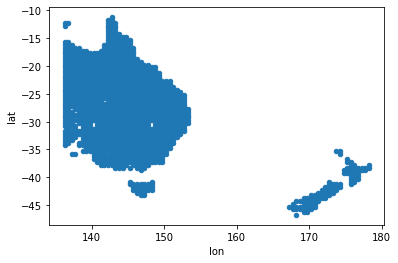

In [4]:
xy.plot(x='lon', y='lat', kind='scatter');

Now get the actual data: it is also tab-separated columnar ASCII format, according to the dataset <a href="https://www.ncei.noaa.gov/pub/data/paleo/treering/reconstructions/australia/palmer2015pdsi/readme-palmer2015anzda.txt" target="_blank">README</a>. That is, one reconstruction per column, with the grid cell number as the column header, and rows are by year with the first column the year index. 

As before use the [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the data in, specifying that the delimiter and that the first column should be treated as the row index. In this case the first line contains useful header information, so that is retained.

In [5]:
url = "https://www.ncei.noaa.gov/pub/data/paleo/treering/reconstructions/australia/palmer2015pdsi/anzda-recon.txt"
data = pd.read_csv(urllib.request.urlopen(url), delimiter='\t', index_col=0)
data

,1,2,3,4,5,6,7,8,9,10,...,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375
Year,,,,,,,,,,,,,,,,,,,,,
1500,0.047,0.192,0.694,0.617,1.331,0.758,1.105,0.320,0.487,0.919,...,0.149,-2.415,-2.645,-1.689,-0.309,-1.834,-0.861,0.409,0.294,-0.922
1501,-1.992,-1.599,-1.086,-1.904,-2.338,-1.585,-1.907,-2.004,-1.522,-1.424,...,0.558,-3.001,-2.530,-1.298,-0.397,0.203,-1.984,0.582,0.919,-0.882
1502,-0.551,-0.491,-0.333,-0.901,-0.550,-1.249,-1.408,-0.623,-0.296,-0.840,...,-0.860,-2.371,-3.420,-3.060,-2.128,-2.107,-0.905,-1.918,-0.450,-1.893
1503,-2.560,-2.793,-1.539,-2.449,-2.696,-2.232,-2.962,-2.576,-1.995,-0.980,...,0.531,-0.522,0.442,0.608,-1.790,0.352,-0.073,-1.621,1.114,-2.080
1504,-1.729,-1.835,-1.514,-1.830,-1.867,-1.225,-1.918,-2.063,-1.577,-0.832,...,-0.739,-2.633,-0.383,-0.389,-2.514,-1.226,-1.999,-2.465,-0.348,-2.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,-1.058,-0.663,-0.271,-1.061,-1.050,-0.613,-0.840,-0.549,-0.103,-0.461,...,2.295,1.619,-2.157,-1.629,1.634,1.566,2.204,1.155,1.769,2.149
2009,-0.072,0.554,0.662,0.923,1.133,0.621,0.410,0.438,1.037,0.895,...,2.048,0.789,-0.924,-0.589,1.424,0.920,1.550,0.982,2.232,1.643
2010,-0.488,0.077,0.295,0.006,1.873,0.237,0.083,0.114,0.400,0.299,...,0.505,-0.491,1.526,1.644,-0.016,-0.050,0.557,-0.255,1.056,0.949


The data is stored as a matrix with associated time and location vectors, so we need to convert from a "wide" to "long" format using the `melt` method, with the result that there is a row for every unique combination of year and location.

Specifying `Year` as an identifier variable means it isn't included in the value column, but is retained as an index. This method will create two new columns with the cell index in one, and the values from the table in other. It has a default names of `variable` and `value`, but better to give them useful names: `cellref` and `pdsi` respectively.                                                                                              

In [6]:
data_long = data.melt(ignore_index=False, var_name = 'cellref', value_name='pdsi')
data_long

,cellref,pdsi
Year,,
1500,1,0.047
1501,1,-1.992
1502,1,-0.551
1503,1,-2.560
1504,1,-1.729
...,...,...
2008,1375,2.149
2009,1375,1.643
2010,1375,0.949


Next is to add the `lat` and `lon` values for each cell index to the data table above. One way to achieve this is to add a `cellref` column to the `xy` table so it can be merged with `data_long` using the `cellref` variable

In [7]:
xy['cellref'] = range(1, len(xy)+1, 1)
xy

,lon,lat,cellref
0,168.25,-46.75,1
1,169.25,-46.25,2
2,169.75,-46.25,3
3,167.75,-45.75,4
4,168.25,-45.75,5
...,...,...,...
1370,142.75,-12.25,1371
1371,143.25,-12.25,1372
1372,142.25,-11.75,1373
1373,142.75,-11.75,1374


Now try [merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)

In [8]:
data_long.merge(xy, on='cellref')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

The `merge` fails with an error message 

`You are trying to merge on object and int64 columns`. 

Inspecting the types (`dtypes`) of the two tables shows the issue, the `cellref` column in `data_long` has a type `object`

In [9]:
xy.dtypes

lon        float64
lat        float64
cellref      int64
dtype: object

In [10]:
data_long.dtypes

cellref     object
pdsi       float64
dtype: object

The solution is to replace the `cellref` column with the same data converted to a number, and try merging again.

In [11]:
data_long['cellref'] = pd.to_numeric(data_long['cellref'])
data_long

,cellref,pdsi
Year,,
1500,1,0.047
1501,1,-1.992
1502,1,-0.551
1503,1,-2.560
1504,1,-1.729
...,...,...
2008,1375,2.149
2009,1375,1.643
2010,1375,0.949


Note at this point `reset_index` is necessary otherwise the `Year` will be lost when merged

In [12]:
data_long = data_long.reset_index().merge(xy, on='cellref')
data_long

,Year,cellref,pdsi,lon,lat
0,1500,1,0.047,168.25,-46.75
1,1501,1,-1.992,168.25,-46.75
2,1502,1,-0.551,168.25,-46.75
3,1503,1,-2.560,168.25,-46.75
4,1504,1,-1.729,168.25,-46.75
...,...,...,...,...,...
705370,2008,1375,2.149,142.75,-11.25
705371,2009,1375,1.643,142.75,-11.25
705372,2010,1375,0.949,142.75,-11.25
705373,2011,1375,3.163,142.75,-11.25


The resulting dataframe has a value of `pdsi` for every year, for every location, with an associated `lat` and `lon` value

## Convert the dataframe to xarray

Now the pandas dataframe can be converted to an `xarray` dataset, which is a well used standard for spatial data analysis. There is a handy function for this purpose, [to_xarray](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_xarray.html).

Some commands are chained before `to_xarray`:`cellref` column is dropped as it is no longer needed, to keep it tidy and case consistent also rename the `Year` column to `year`, and finally `set_index` creates a multi-index. All the index variables will automatically be converted to coordinates in the `xarray` object. The order of variables in `set_index` is also important: longitude is set to be the fastest varying axis/index, which will result in plots being correctly oriented by default

In [13]:
ds = data_long.drop('cellref', axis=1).rename(columns={'Year': 'year'}).set_index(['year', 'lat', 'lon']).to_xarray()

In [14]:
ds

<xarray.Dataset>
Dimensions:  (year: 513, lat: 72, lon: 58)
Coordinates:
  * year     (year) int64 1500 1501 1502 1503 1504 ... 2008 2009 2010 2011 2012
  * lat      (lat) float64 -46.75 -46.25 -45.75 -45.25 ... -12.25 -11.75 -11.25
  * lon      (lon) float64 136.2 136.8 137.2 137.8 ... 176.8 177.2 177.8 178.2
Data variables:
    pdsi     (year, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

Plot as a sanity check using the in-built `plot` method. 

There appears to be a problem: data extended into the Tasman sea from both land masses.

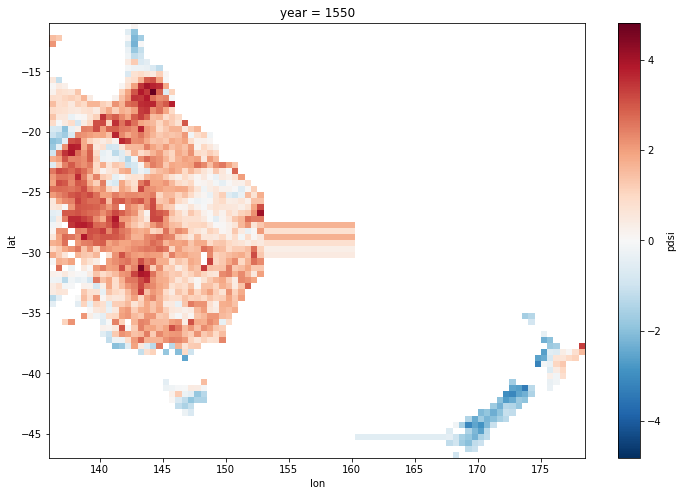

In [15]:
ds.pdsi.isel(year=50).plot(size = 8);

Looking at the difference between each longitude point and it's neighbour shows the problem: there is difference of -14. at one point, so there is a gap in the coordinates in the Tasman Sea. This is because there are no data points with those longitudes in the original data set.

In [16]:
ds.coords['lon'] - ds.coords['lon'].shift({'lon':-1})

<xarray.DataArray 'lon' (lon: 58)>
array([ -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,
        -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,
        -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,
        -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5, -14. ,  -0.5,
        -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,
        -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,  -0.5,
        -0.5,  -0.5,  -0.5,   nan])
Coordinates:
  * lon      (lon) float64 136.2 136.8 137.2 137.8 ... 176.8 177.2 177.8 178.2

Fix this by creating a new longitude coordinate that spans the whole range with the same 0.5 degree spacing

In [17]:
ds = ds.reindex(lon = xr.DataArray(np.arange(ds.lon.min(), ds.lon.max()+0.5, 0.5), dims=['lon']))

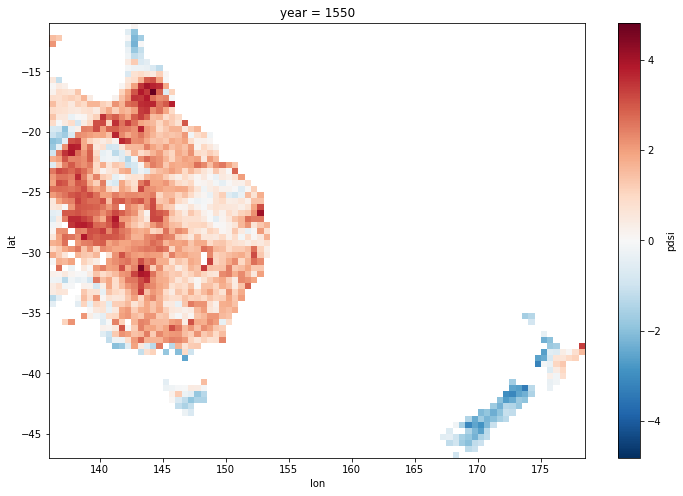

In [18]:
ds.pdsi.isel(year=50).plot(x='lon',y='lat', size = 8);

## Save data for reuse

First step is to add some meta-data. The website says:

> Use Constraints:

> Please cite original publication, online resource, dataset and publication DOIs (where available), and date accessed when using downloaded data. If there is no publication information, please cite investigator, title, online resource, and date accessed. The appearance of external links associated with a dataset does not constitute endorsement by the Department of Commerce/National Oceanic and Atmospheric Administration of external Web sites or the information, products or services contained therein. For other than authorized activities, the Department of Commerce/NOAA does not exercise any editorial control over the information you may find at these locations. These links are provided consistent with the stated purpose of this Department of Commerce/NOAA Web site.

Set the global (dataset level) attributes

In [19]:
ds.attrs = {
    "title": "Eastern Australia and New Zealand Drought Atlas (ANZDA)",
    "creator_name": "Palmer, J.G.; Cook, E.R.; Turney, C.S.M.; Allen, K.J.; Fenwick, P.; Cook, B.I.; O'Donnell, A.J.; Lough, J.M.; Grierson, P.F.; Baker, P.J.",
    "publisher": "National Centers for Environmental Information, NESDIS, NOAA, U.S. Department of Commerce",
    "references": "Jonathan G. Palmer, Edward R. Cook, Chris S.M. Turney, Kathy Allen, Pavla Fenwick, Benjamin I. Cook, Alison O'Donnell, Janice Lough, Pauline Grierson, Patrick Baker. 2015. Drought variability in the eastern Australia and New Zealand summer drought atlas (ANZDA, CE 1500-2012) modulated by the Interdecadal Pacific Oscillation. Environmental Research Letters, 10(12), 124002. doi:10.1088/1748-9326/10/12/124002",
    "keywords": "Palmer Drought Index Reconstruction, drought, paleoclimate",
    "date_created": "2016-06-06",
    "source": "https://www.ncei.noaa.gov/access/paleo-search/study/20245",
    "source_license": "Please cite original publication, online resource, dataset and publication DOIs (where available), and date accessed when using downloaded data. If there is no publication information, please cite investigator, title, online resource, and date accessed. The appearance of external links associated with a dataset does not constitute endorsement by the Department of Commerce/National Oceanic and Atmospheric Administration of external Web sites or the information, products or services contained therein. For other than authorized activities, the Department of Commerce/NOAA does not exercise any editorial control over the information you may find at these locations. These links are provided consistent with the stated purpose of this Department of Commerce/NOAA Web site.",
    "date_downloaded": datetime.today().strftime('%Y-%m-%d'),
    "geospatial_lat_min": -47.0,
    "geospatial_lat_max": -11.0,
    "geospatial_lon_min": 136.0,
    "geospatial_lon_max": 178.5,
    "time_coverage_start": "450 cal yr BP (1500 CE)",
    "time_coverage_end": "-62 cal yr BP (2012 CE)",
}

Next set variable level attributes

In [20]:
ds.pdsi.attrs = {
    "name": "Palmer drought severity index",
    "long_name": "Reconstructions of JJA Palmer drought severity index reconstruction series for 1375 Gridpoints",
    "units": "",
}

Check the attributes have been specified correctly

In [21]:
ds

<xarray.Dataset>
Dimensions:  (lon: 85, year: 513, lat: 72)
Coordinates:
  * lon      (lon) float64 136.2 136.8 137.2 137.8 ... 176.8 177.2 177.8 178.2
  * year     (year) int64 1500 1501 1502 1503 1504 ... 2008 2009 2010 2011 2012
  * lat      (lat) float64 -46.75 -46.25 -45.75 -45.25 ... -12.25 -11.75 -11.25
Data variables:
    pdsi     (year, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/15)
    title:                Eastern Australia and New Zealand Drought Atlas (AN...
    creator_name:         Palmer, J.G.; Cook, E.R.; Turney, C.S.M.; Allen, K....
    publisher:            National Centers for Environmental Information, NES...
    references:           Jonathan G. Palmer, Edward R. Cook, Chris S.M. Turn...
    keywords:             Palmer Drought Index Reconstruction, drought, paleo...
    date_created:         2016-06-06
    ...                   ...
    geospatial_lat_min:   -47.0
    geospatial_lat_max:   -11.0
    geospatial_lon_min:   136.0
    geospatial_lon_max:   178.5
    time_coverage_start:  450 cal yr BP (1500 CE)
    time_coverage_end:    -62 cal yr BP (2012 CE)

Save to a netcdf file

In [22]:
ds.to_netcdf("anzda_recon.nc", format = "NETCDF4")

Dump the file header to check it looks ok

In [23]:
!ncdump -h ~/anzda_recon.nc

netcdf anzda_recon {
dimensions:
	lon = 85 ;
	year = 513 ;
	lat = 72 ;
variables:
	double lon(lon) ;
		lon:_FillValue = NaN ;
	int64 year(year) ;
	double lat(lat) ;
		lat:_FillValue = NaN ;
	double pdsi(year, lat, lon) ;
		pdsi:_FillValue = NaN ;
		pdsi:name = "Palmer drought severity index" ;
		pdsi:long_name = "Reconstructions of JJA Palmer drought severity index reconstruction series for 1375 Gridpoints" ;
		pdsi:units = "" ;

// global attributes:
		:title = "Eastern Australia and New Zealand Drought Atlas (ANZDA)" ;
		:creator_name = "Palmer, J.G.; Cook, E.R.; Turney, C.S.M.; Allen, K.J.; Fenwick, P.; Cook, B.I.; O\'Donnell, A.J.; Lough, J.M.; Grierson, P.F.; Baker, P.J." ;
		:publisher = "National Centers for Environmental Information, NESDIS, NOAA, U.S. Department of Commerce" ;
		:references = "Jonathan G. Palmer, Edward R. Cook, Chris S.M. Turney, Kathy Allen, Pavla Fenwick, Benjamin I. Cook, Alison O\'Donnell, Janice Lough, Pauline Grierson, Patrick Baker. 2015. Drought varia

Note: The year coordinate remains an integer, and has not been converted to a datetime format. It is possible to do so, but `pandas` does not support datetimes earlier than `1677-09-21 00:12:43.145225` and later than `2262-04-11 23:47:16.854775807`. It is possible to convert to a [cftime index](https://xarray.pydata.org/en/stable/generated/xarray.CFTimeIndex.html), but it was not done for this example. Reasons to do so would be to use time based resampling or groupby.